<a href="https://colab.research.google.com/github/flokoafon/WQU_project/blob/WQU/WQU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import io
import datetime
import statsmodels.api as sm
from google.colab import files

In [6]:
url = "https://raw.githubusercontent.com/flokoafon/WQU_project/main/ProjectData.xlsx"
series = pd.read_excel(url)
series.head()

,Date,DPI,IPI,COP,SIR,LTIR,NGP
0,2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
1,2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2,2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
3,2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
4,2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN


In [7]:
series.tail()

,Date,DPI,IPI,COP,SIR,LTIR,NGP
262,2021-11-01,15100.129883,94.29214,79.18,-0.52,-0.313636,NaN
263,2021-12-01,15884.860352,95.79202,71.69,-0.58,-0.384286,NaN
264,2022-01-01,15471.200195,96.39197,82.98,-0.50,-0.114762,NaN
265,2022-02-01,14461.019531,96.49196,91.63,-0.48,0.150000,NaN
266,2022-03-01,14414.750000,NaN,108.26,NaN,0.280000,NaN


As you'll see it in the report, the abreviations used above have the following meanings:
DPI: Dax Performance Index
IPI: Industrial Production Index
COP: Crude Oil Price
SIR: Short term Interest Rate
LTIR: Long-Term Interest Rate
NGP: Natural Gas Price

In [8]:
#Defining date column as index
#series['Date'] = pd.to_datetime(series['Date'], dayfirst = True)
series.set_index('Date', inplace = True)
series

,DPI,IPI,COP,SIR,LTIR,NGP
Date,,,,,,
2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN
...,...,...,...,...,...,...
2021-11-01,15100.129883,94.29214,79.18,-0.52,-0.313636,NaN
2021-12-01,15884.860352,95.79202,71.69,-0.58,-0.384286,NaN
2022-01-01,15471.200195,96.39197,82.98,-0.50,-0.114762,NaN


In [9]:
#Select date where all series are available
#This because npg serie is only available between 01/01/2007 and 01/06/2021
intermediate = series.reset_index()
first = intermediate.loc[intermediate['Date']=='2007-01-01']
last = intermediate.loc[intermediate['Date']=='2021-06-01']
begin = first.index[0]
end = last.index[0]
complete_series = intermediate.loc[begin:end,]

In [10]:
#Complete_series is the dateframe containing all the rows of series with available data
complete_series

,Date,DPI,IPI,COP,SIR,LTIR,NGP
84,2007-01-01,6789.109863,95.09208,54.35,3.48,4.016818,2.4168
85,2007-02-01,6715.439941,95.49204,59.39,3.50,4.049000,2.4168
86,2007-03-01,6917.029785,95.99200,60.74,3.67,3.940909,2.4168
87,2007-04-01,7408.870117,95.09208,64.04,3.72,4.152105,2.4168
88,2007-05-01,7883.040039,96.79193,63.53,3.76,4.279048,2.4168
...,...,...,...,...,...,...,...
253,2021-02-01,13786.290039,95.19207,59.06,-0.26,-0.445500,2.0592
254,2021-03-01,15008.339844,95.89201,62.36,-0.12,-0.364783,2.0592
255,2021-04-01,15135.910156,95.69202,61.70,-0.25,-0.325000,2.0592
256,2021-05-01,15421.129883,95.19207,65.16,-0.34,-0.223500,2.0592


In the following cells, we plot the different series in order to have first apppreciations of their behaviors

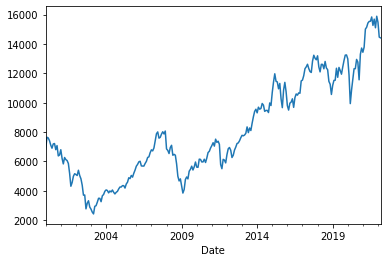

In [11]:
#First vizualisation of data
DPI = series['DPI']
DPI.plot()

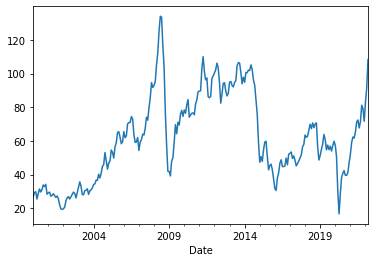

In [12]:
COP =series['COP']
COP.plot()

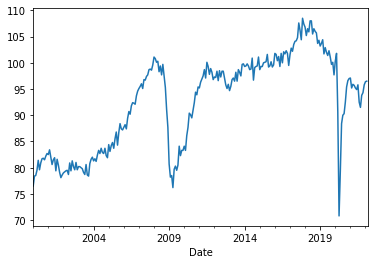

In [13]:
IPI = series['IPI']
IPI.plot()

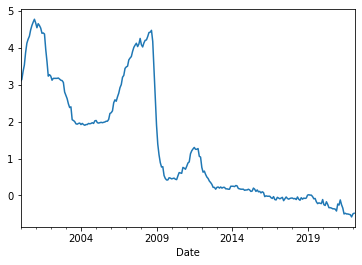

In [14]:
SIR = series['SIR']
SIR.plot()

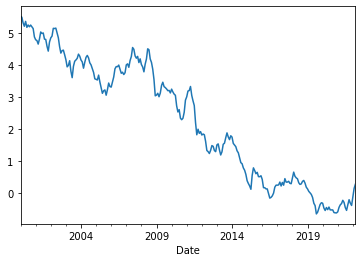

In [43]:
LTIR = series['LTIR']
LTIR.plot()

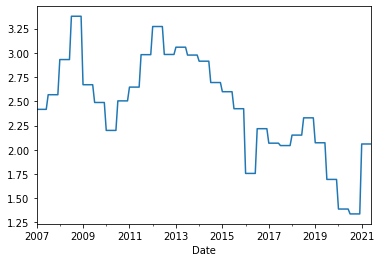

In [15]:
complete_series.set_index('Date', inplace = True)
NGP = complete_series['NGP']
NGP.plot()

In [16]:
# Compute some descriptive statistics
series.describe()

,DPI,IPI,COP,SIR,LTIR,NGP
count,267.000000,266.000000,267.000000,266.000000,267.000000,174.000000
mean,8100.129177,92.554318,61.425094,1.379850,2.304052,2.441931
std,3385.521911,8.941259,25.681007,1.610145,1.905739,0.514635
min,2423.870117,70.794100,16.700000,-0.580000,-0.649091,1.337200
25%,5603.625000,82.943088,40.970000,-0.017500,0.347702,2.071700
50%,7158.770020,95.592030,59.060000,0.615000,2.615909,2.487600
75%,11059.034668,99.391720,80.425000,2.657500,4.022273,2.914000
max,15884.860352,108.491000,134.020000,4.770000,5.539524,3.378000


In the followings we study seasonnality of each series by 

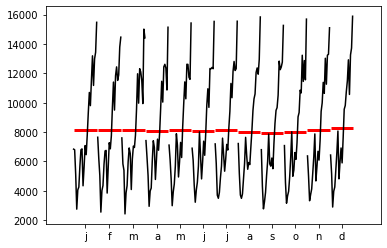

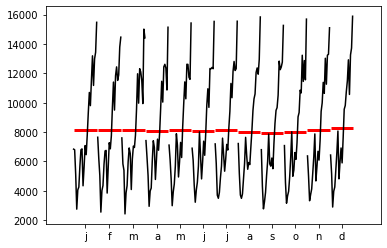

In [15]:
#Monthplot for DPI
sm.graphics.tsa.month_plot(DPI)

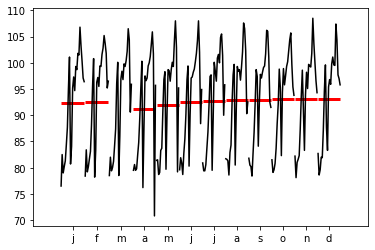

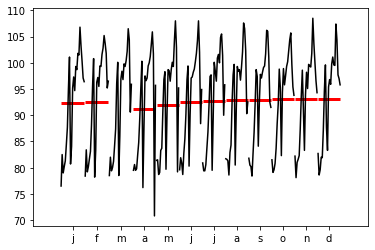

In [16]:
#Monthplot for IPI
sm.graphics.tsa.month_plot(IPI)

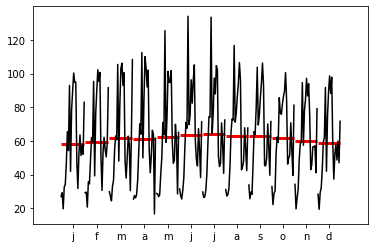

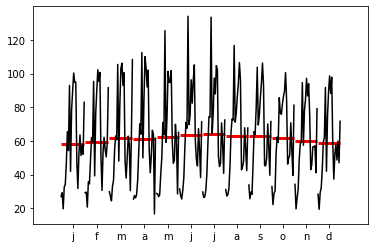

In [17]:
#Monthplot for COP
sm.graphics.tsa.month_plot(COP)

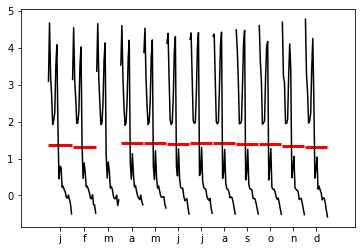

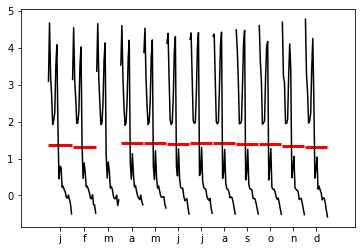

In [18]:
#Monthplot for SIR
sm.graphics.tsa.month_plot(SIR)

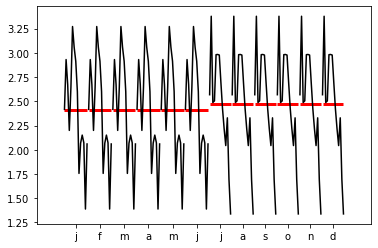

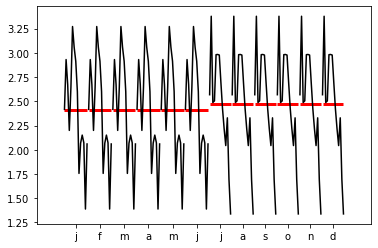

In [19]:
#Monthplot for NGP
sm.graphics.tsa.month_plot(NGP)

As we can see it, almost series don't have a seasonnal component. But the series of DPI and SIR seem to present trends and thus are not stationnary.The other series don't present trend but have values that far differ from their initial values with time. That is the sign of an unconstant variance and thus they are not stationnary. But we will perform unit root testing using Augmented Dickey-Fuller Test to confirm all of this.

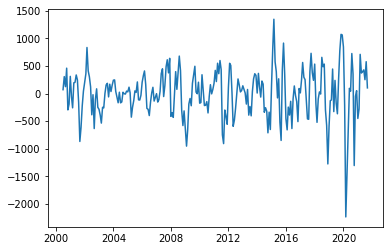

In [17]:
#As DPI present a trend, we have to remove this tend in order to make the serie stationnary
#The serie will be decompose in trend, seasonnality and residuals
#We use the additive model because there seasonnal effect is marginal over time
DPI_decomposition = sm.tsa.seasonal_decompose(DPI)
resid = DPI_decomposition.resid #residual of the decomposition
plt.plot(resid)

In [18]:
#Testing previous residuals to make sure that they are stationary
#Model with constant term and trend
notnull_resid = resid[resid.notnull()]
sm.tsa.stattools.adfuller(x = notnull_resid, regression="ct")

(-7.2416522296456565,
 1.7341585285868223e-11,
 10,
 244,
 {'1%': -2.574964035877452,
  '10%': -1.6157753152576646,
  '5%': -1.9421551907566053},
 3453.585672305444)

In [19]:
#Model with constant term only
sm.tsa.stattools.adfuller(x = notnull_resid, regression="c")

(-7.234986853761029,
 1.9500926294488824e-10,
 10,
 244,
 {'1%': -3.457437824930831,
  '10%': -2.573122099570008,
  '5%': -2.873459364726563},
 3455.504803205163)

In [20]:
#Model without constant term and trend
sm.tsa.stattools.adfuller(x = notnull_resid, regression="nc")

(-7.2416522296456565,
 1.7341585285868223e-11,
 10,
 244,
 {'1%': -2.574964035877452,
  '10%': -1.6157753152576646,
  '5%': -1.9421551907566053},
 3453.585672305444)

The unit root test with ADF procedure begin by including constant term and trend. If the null hypothesis of not stationarity is rejected, we perform the model includind only the constant. With the previous residuals (DPI without trend), the model including constant term and trend was not significant and we performed model with constant term only. This model was also unsignificant. Thus we performed model including neither constant term nor trend. We lead to the conclusion that DPI residuals are stationnary.

We now move to the test of COP'stationnarity. We also use ADF procedure.

In [21]:
#Model with constant term and trend
sm.tsa.stattools.adfuller(x = COP, regression="ct")

(-2.689585972283409,
 0.2404319686308522,
 1,
 265,
 {'1%': -3.993344663514176, '10%': -3.136864075512, '5%': -3.427188657495785},
 1552.0288414576419)

As we can see above, the null hypothesis of non stationnarity is not rejected for the first model including constant term and trend. The serie will be differenciation and the test reperformed

In [22]:
first_difference_COP = COP.diff()
first_difference_COP = first_difference_COP[first_difference_COP.notnull()]
sm.tsa.stattools.adfuller(x = first_difference_COP, regression="nc")

(-10.581826035629947,
 5.470873669011234e-19,
 0,
 265,
 {'1%': -2.574228629405482,
  '10%': -1.615855020103844,
  '5%': -1.9420598245262868},
 1548.4868559980976)

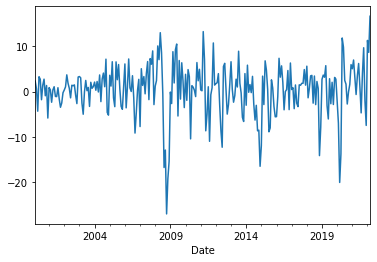

In [23]:
first_difference_COP.plot()

As shown above by the p-value and critical values the first differenciation of COP serie (plotted above) produce a serie that is stationnary.

In [24]:
#Study of IPI'serie stationnarity
first_difference_IPI = IPI.diff()
first_difference_IPI = first_difference_IPI[first_difference_IPI.notnull()]
#Model with constant term and trend
sm.tsa.adfuller(first_difference_IPI, regression="ct")

(-13.69893492740872,
 2.135086296700091e-21,
 1,
 263,
 {'1%': -3.9936108014436673,
  '10%': -3.1369391540293634,
  '5%': -3.4273166669275947},
 1096.9603733183922)

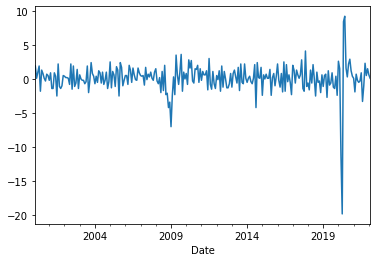

In [26]:
first_difference_IPI.plot()

We now move on the treatment of the SIR'serie that obviuosly isn't stationnary. This serie present a decreasing trend. So, we have to decompose this serie in order to remove this trend.

In [27]:
#Decomposition in trend and residuals
SIR_notnull = SIR[SIR.notnull()] #getting not null values of SIR serie
SIR_decomposition = sm.tsa.seasonal_decompose(SIR_notnull)
SIR_resid = SIR_decomposition.resid
SIR_resid

Date
2000-01-01   NaN
2000-02-01   NaN
2000-03-01   NaN
2000-04-01   NaN
2000-05-01   NaN
              ..
2021-10-01   NaN
2021-11-01   NaN
2021-12-01   NaN
2022-01-01   NaN
2022-02-01   NaN
Name: SIR, Length: 266, dtype: float64

In [28]:
#Checking stationnarity of residuals of decomposition of SIR serie
SIR_resid_notnull = SIR_resid[SIR_resid.notnull()]
#Model with trend and constant term
sm.tsa.adfuller(SIR_resid_notnull, regression = "ct")

(-8.499688080654392,
 5.025180725673607e-12,
 3,
 250,
 {'1%': -3.99544583392, '10%': -3.13745663232, '5%': -3.428199079936},
 -560.8802212052749)

In [29]:
#Model without trend but with constant term
sm.tsa.adfuller(SIR_resid_notnull, regression = "c")

(-8.509244595670305,
 1.1797047804303536e-13,
 3,
 250,
 {'1%': -3.456780859712, '10%': -2.572968544, '5%': -2.8731715065600003},
 -562.8781183470307)

In [30]:
#Model without trend and constant term
sm.tsa.adfuller(SIR_resid_notnull, regression = "nc")

(-8.526175703417646,
 2.0626495191564132e-14,
 3,
 250,
 {'1%': -2.574741232, '10%': -1.615799400704, '5%': -1.942126241728},
 -564.8781177388582)

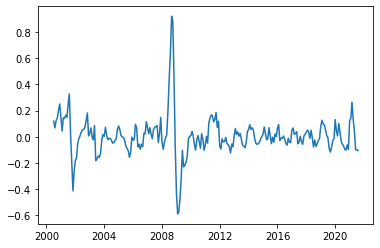

In [31]:
#Plotting residuals of SIR decomposition for graphic checking of stationnarity
plt.plot(SIR_resid_notnull)

The results of the three tests performed above and the previous graphic show that the SIR serie is stationnary at the first difference. We can also say that the SIR serie is integrated at the first order I(1).

Treatment of the LTIR serie by studying stationnarity.
The graph of LTIR show a decreasing trend and thus thi serie is not stationary. We have to remove trend in the serie in order to make it stationary.

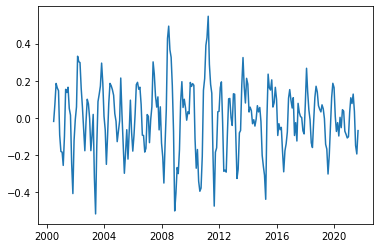

In [44]:
#In order to detrend the serie of LTIR, as for DPI serie, we decompose it and conserv residuals
LTIR_decomposition = sm.tsa.seasonal_decompose(LTIR)
LTIR_resid = LTIR_decomposition.resid #residual of the decomposition
plt.plot(LTIR_resid)

In [45]:
#Testing previous residuals to make sure that they are stationary
#Model with constant term and trend
notnull_resid = LTIR_resid[LTIR_resid.notnull()]
sm.tsa.stattools.adfuller(x = notnull_resid, regression="ct")

(-10.118756003815042,
 1.2963755701638797e-15,
 4,
 250,
 {'1%': -3.99544583392, '10%': -3.13745663232, '5%': -3.428199079936},
 -361.4501951399425)

Given the results of the previous tests, we conclude that the residuals are stationary.

**All our series are not stationnary. DPI, LTIR and SIR series are trend stationary (TS) so we only have to remove the trend in order to make it stationary. The other series (IPI, COP) are differencing stationary (DS). We differenciate them is order to get the stationnarity.** Now we move to the study of relationships between pairs of variables. We begin by plotting the dispersion matrix of data.

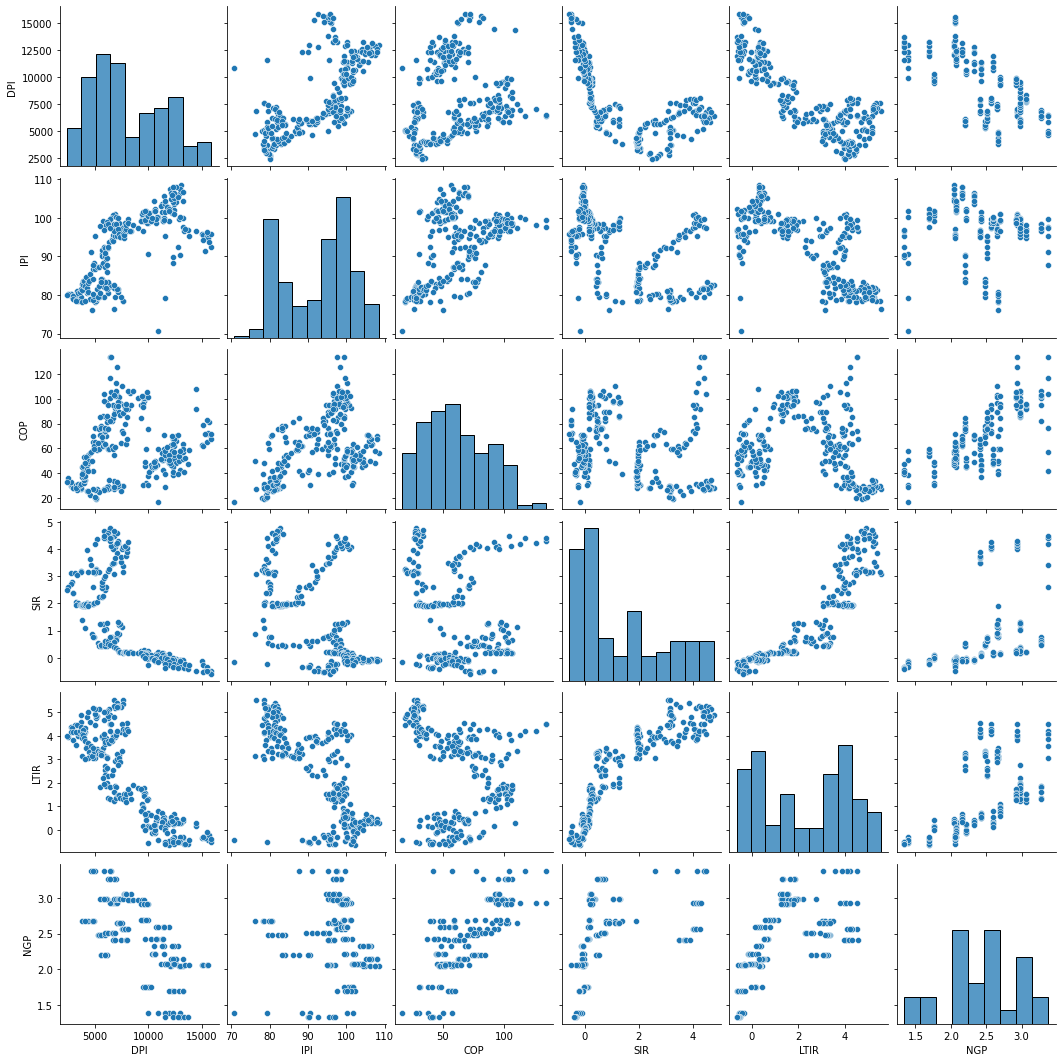

In [42]:
#Dispersion between the variables
sns.pairplot(series)

The plot between DPI and LTIR exhibit a linear relationship. So we can check if there is cointegration between those variables. 

In [47]:
#Checking cointegration between DPI and SIR using Augmented Engle-Granger two-step cointegration test
full_size_DPI = DPI[0:266,] #this variables contains the DPI'serie corresponding values of not null values of SIR serie
sm.tsa.stattools.coint(DPI, LTIR, trend = "c") #Model with constant term and trend

(-3.073332165432992,
 0.093785592205127,
 array([-3.9380864 , -3.35919673, -3.0604328 ]))

In [64]:
#Checking cointegration between DPI and LTIR using Augmented Engle-Granger two-step cointegration test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johansen_series = series[['DPI','LTIR']] #Data for testing cointegration
johansen_series = johansen_series[johansen_series.notnull()] #Removing all not numeric data in the matrix
result = coint_johansen(endog = johansen_series, det_order = 1, k_ar_diff = 1)
dir(result)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cvm',
 'cvt',
 'eig',
 'evec',
 'ind',
 'lr1',
 'lr2',
 'meth',
 'r0t',
 'rkt']

In [66]:
print(result.cvm, result.cvt, result.eig, result.evec)


[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]] [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]] [0.05768324 0.0308481 ] [[ 5.10048148e-04 -3.99972724e-04]
 [ 1.25175704e+00  1.73127089e+00]]
